In [38]:
## IMPORT 

import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
from scipy.signal import resample
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import h5py as h5
import h5py
from pathlib import Path
import matplotlib as mpl

In [39]:
# Text   
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.family'] = '.SF Camera'

# Boxes
mpl.rcParams['axes.spines.top']= False
mpl.rcParams['axes.spines.right']= False

# plt.rcParams['figure.figsize'] = [4, 5]
plt.rcParams['figure.dpi'] = 140

In [40]:
## LOADING THE MF HDF5 File 

filename='1035_M_0014.doric'
folder = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/NOR_BLA/raw'
h5file = os.path.join(folder, filename)

## LOADING ANYMAZE FILE FOR TTL

TTL_an=pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/NOR_BLA/am/1035_test_NOR.csv')

## LOADING ANYMAZE POSITION FILE 

ampos=pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/NOR_BLA/ampos/1035_test_NORpos.csv')
pd.DataFrame(ampos)
# Extract ID, sex and stage of experiment

base_name = os.path.basename(filename)
name_parts = base_name.split('_')
mouse_id = name_parts[0]
sex = name_parts[1]



with h5py.File(h5file, 'r') as f:
    # Find the channel signal from DORIC file
    folder = f['DataAcquisition']['EPConsole']['Signals']['Series0001']
    
    # Get time
    raw_time = folder['AIN01xAOUT01-LockIn']['Time']
    

    # Get signal
    values_gcamp = folder['AIN01xAOUT01-LockIn']['Values']
    values_iso = folder['AIN01xAOUT02-LockIn']['Values']
    values_rcamp = folder['AIN02xAOUT03-LockIn']['Values']

    #Get TLL 
    raw_dio_time = folder['DigitalIO']['Time']
    raw_TTL_wn = folder['DigitalIO']['DIO02']
    raw_TTL_tone = folder['DigitalIO']['DIO03']


    #Read the data 
    raw_time = raw_time[:]
    values_gcamp = values_gcamp[:]
    values_iso =  values_iso[:]
    values_rcamp = values_rcamp[:]
    raw_TTL_wn = raw_TTL_wn[:]
    raw_TTL_tone = raw_TTL_tone[:]
    raw_dio_time = raw_dio_time[:]

    #Sanity check for the win
    print("Raw Time (first 5):", raw_time[:5])
    print("Values gcamp (first 5):", values_gcamp[:5])
    print("values rcamp (first 5)", values_rcamp[:5])
    print("Values iso (first 5):", values_iso[:5])
    print("raw dio time (first 5)", raw_dio_time[:5])
    print("TTL_wn:", raw_TTL_wn[:5])
    print(len(values_gcamp))
    print(len(raw_TTL_tone))


Raw Time (first 5): [0.083083 0.099683 0.116283 0.132883 0.149483]
Values gcamp (first 5): [0.13322948 0.13286279 0.13246791 0.13204809 0.13184733]
values rcamp (first 5) [7.37900129e-05 6.01933968e-05 1.67413400e-04 1.37109990e-04
 3.97398776e-05]
Values iso (first 5): [0.15388182 0.15363674 0.15332924 0.15291202 0.15248444]
raw dio time (first 5) [0.     0.0166 0.0332 0.0498 0.0664]
TTL_wn: [0. 0. 0. 0. 0.]
32523
32533


Average Sampling Interval: 0.0166 seconds
Sampling Frequency: 60.24096385542168 Hz
duration:, 539.8652000000001 seconds
Average Sampling Interval after resampling: 0.016672258582366005 seconds
Sampling Frequency after resampling: 59.979875855433576 Hz
(32392,)
(32392,)
(32392,)
539.9482830000001
540.0312


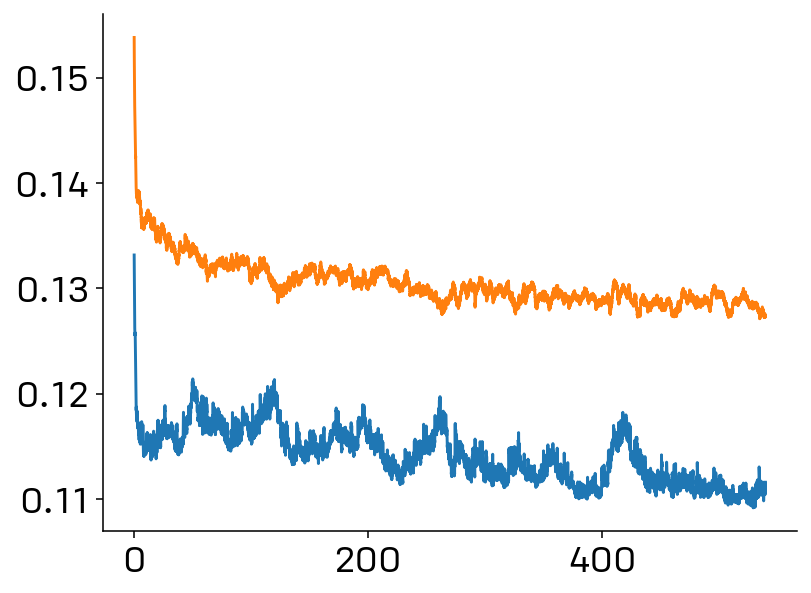

In [41]:
#RESAMPLING 
##Check the sampling 

# Calculate the differences between consecutive time points
time_differences = np.diff(raw_time)
average_sampling_interval = np.mean(time_differences)

# Calculate the sampling frequency
sampling_frequency = 1 / average_sampling_interval

print(f"Average Sampling Interval: {average_sampling_interval} seconds")
print(f"Sampling Frequency: {sampling_frequency} Hz")


### RESAMPLING 
duration = raw_time[-1] - raw_time[0]

new_sampling_rate = 60  # Hz
num_samples_resampled = int(duration * new_sampling_rate) + 1 ##Integer because can't be a fraction

# Resample gcamp + iso + TTL 
resampled_gcamp, time = resample(values_gcamp, num_samples_resampled, t=raw_time)
resampled_rcamp, time = resample(values_rcamp, num_samples_resampled, t=raw_time)
resampled_iso, time = resample(values_iso, num_samples_resampled, t=raw_time)
resampled_TTL_wn, time = resample(raw_TTL_wn, num_samples_resampled, t=raw_time) ##CAREFUL USING THIS, TTL TIME IS HERE CONSIDERED AS GCAMP TIME, IT'S AN APPROXIMATION, ALWAYS CHECK IF MAKES SENSE
resampled_TTL_tone, time = resample(raw_TTL_tone, num_samples_resampled, t=raw_time) ##CAREFUL USING THIS, TTL TIME IS HERE CONSIDERED AS GCAMP TIME, IT'S AN APPROXIMATION, ALWAYS CHECK IF MAKES SENSE

print(f"duration:, {duration} seconds")

## Sanity check for the win 
time_differences_resampled = np.diff(time)
average_sampling_interval_resampled = np.mean(time_differences_resampled)
sampling_frequency_resampled = 1 / average_sampling_interval_resampled

print(f"Average Sampling Interval after resampling: {average_sampling_interval_resampled} seconds")
print(f"Sampling Frequency after resampling: {sampling_frequency_resampled} Hz")
print(resampled_gcamp.shape)
print(resampled_rcamp.shape)
print(resampled_TTL_wn.shape)
print(raw_time[-1])
print(raw_dio_time[-1])

plt.plot(time, resampled_gcamp)
plt.plot(time, resampled_iso)

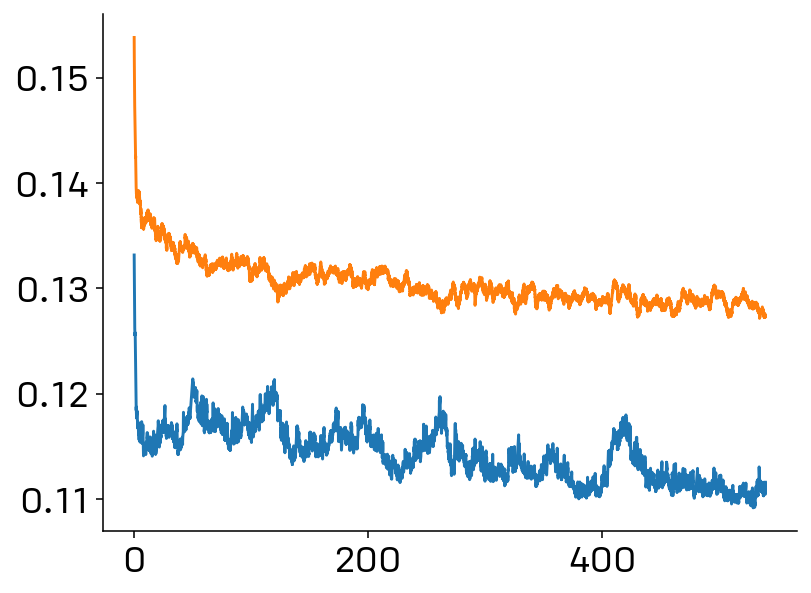

In [42]:
###Removing artifacts 

import numpy as np
from scipy.interpolate import interp1d

def remove_artifacts_and_interpolate(signal, time, threshold=0.0005, time_window=0.5):
    # Create a copy of the original signal
    cleaned_signal = signal.copy()

    # Define the sliding window size based on the time window
    window_size = np.sum(time <= time_window)

    # Iterate through the signal using a sliding window
    for i in range(len(cleaned_signal) - window_size):
        # Calculate the difference in signal within the window
        window_diff = cleaned_signal[i + window_size] - cleaned_signal[i]

        # If the difference exceeds the threshold, mark it as NaN
        if window_diff > threshold:
            cleaned_signal[i:i + window_size] = np.nan

    # Interpolate the NaN values
    nan_indices = np.isnan(cleaned_signal)
    interpolator = interp1d(time[~nan_indices], cleaned_signal[~nan_indices], kind='linear', fill_value='extrapolate')
    cleaned_signal[nan_indices] = interpolator(time[nan_indices])

    return cleaned_signal

# Apply the function to both 'resampled_gcamp' and 'resampled_iso'
resampled_gcamp = remove_artifacts_and_interpolate(resampled_gcamp, time)
resampled_iso = remove_artifacts_and_interpolate(resampled_iso, time)
resampled_rcamp = remove_artifacts_and_interpolate(resampled_rcamp, time)

# 'resampled_gcamp' and 'resampled_iso' now contain the cleaned signals


plt.plot(time, resampled_gcamp)
plt.plot(time, resampled_iso)

In [43]:
####ABBERRANCE DETECTION : WHEN SIGNAL FUCKS UP - PATCHCORD gets detached

# Calculate the first derivative of the signal
signal_diff = np.diff(resampled_gcamp, prepend=resampled_gcamp[0])

# Set a threshold for detecting large jumps in the signal
threshold = np.std(signal_diff) * 20  # Adjust the factor as needed

# Identify the indices where the signal changes significantly
power_change_indices = np.where(np.abs(signal_diff) > threshold)[0]

print("Detected power change points at indices:", power_change_indices)

Detected power change points at indices: []


Signal successfully scaled across segments!


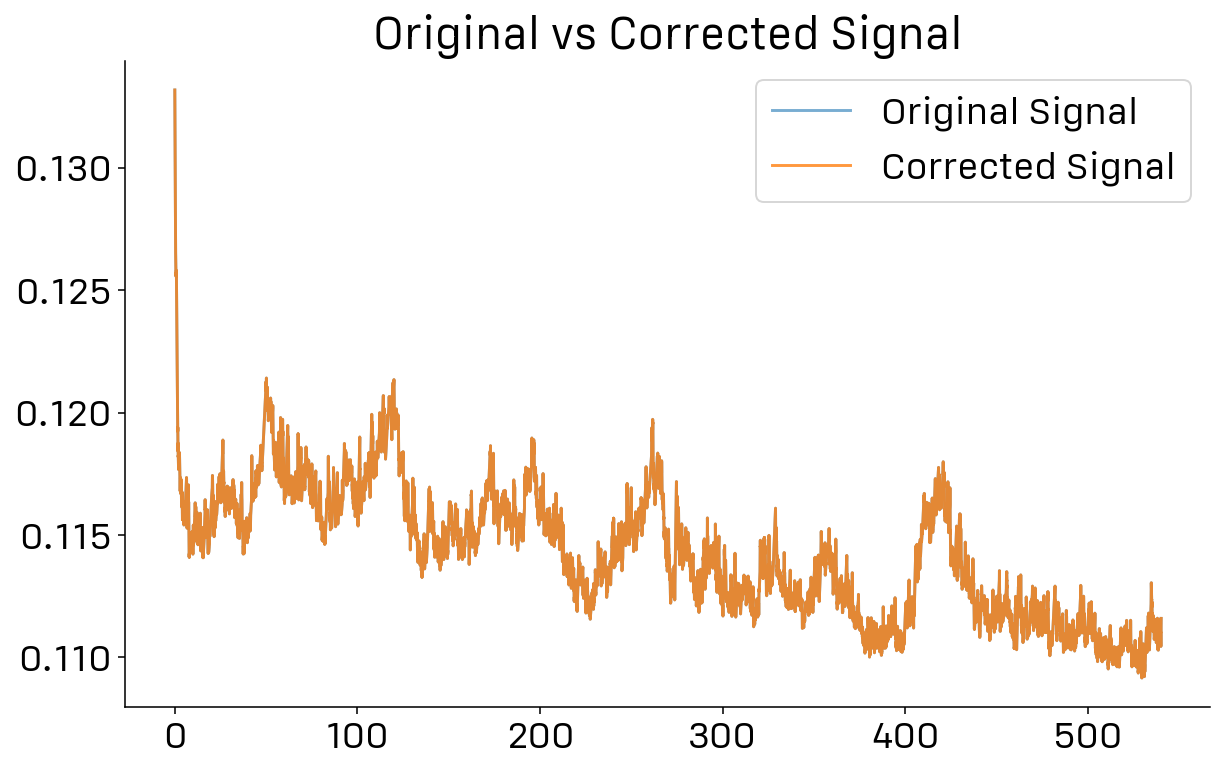

32392

In [44]:
#CORRECT THE ABBERATION

# Your resampled_gcamp signal and detected power change indices
# resampled_gcamp is your signal array
# power_change_indices contains the indices where signal changes (detected earlier)
# Include the start and end of the signal in the indices
power_change_indices = np.concatenate(([0], power_change_indices, [len(resampled_gcamp)]))

# Initialize an array to store the corrected signal
corrected_signal = np.copy(resampled_gcamp)

# Scale each segment based on the mean of the first segment
base_mean = np.mean(resampled_gcamp[power_change_indices[0]:power_change_indices[1]])

# Loop over each segment and scale them
for i in range(len(power_change_indices) - 1):
    start_idx = power_change_indices[i]
    end_idx = power_change_indices[i + 1]

    # Calculate the mean of the current segment
    segment_mean = np.mean(resampled_gcamp[start_idx:end_idx])

    # Compute the scaling factor
    scaling_factor = base_mean / segment_mean

    # Scale the segment
    corrected_signal[start_idx:end_idx] *= scaling_factor

# Now corrected_signal contains the adjusted signal
print("Signal successfully scaled across segments!")

plt.figure(figsize=(10,6))
plt.plot(time, resampled_gcamp, label='Original Signal', alpha=0.6)
plt.plot(time, corrected_signal, label='Corrected Signal', alpha=0.8)
plt.legend()
plt.title('Original vs Corrected Signal')
plt.show()

len(resampled_gcamp)
# len(corrected_signal)


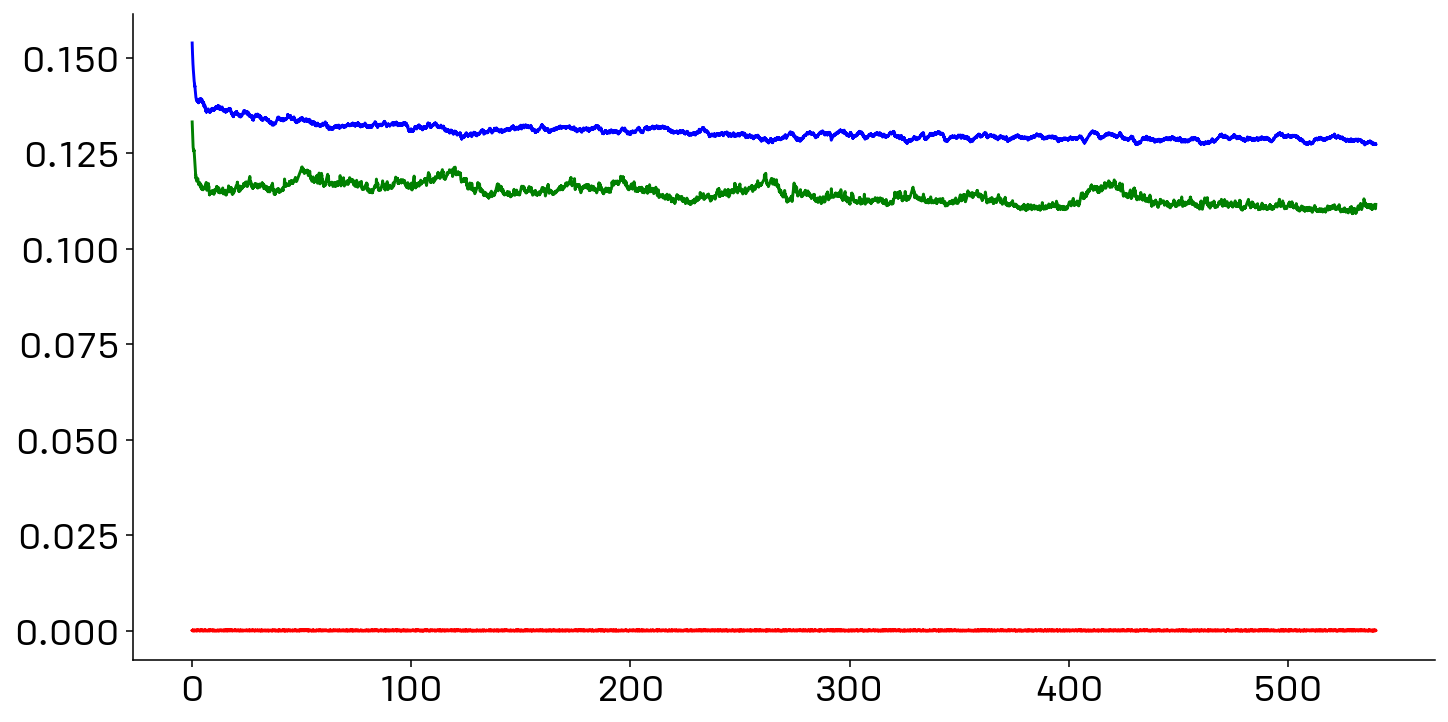

In [45]:

##RAW SIGNAL PLOT

# fig,ax1=plt.subplots(figsize=(12,6))  # create a plot to allow for dual y-axes plotting
# plot1=ax1.plot(time, resampled_gcamp, 'g', label='gcamp') 
# ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
# plot2=ax2.plot(time, resampled_iso, 'r', label='isosbestic') 
# # Labels
# lines = plot1 + plot2
# labels = [l.get_label() for l in lines]  
# legend = ax1.legend(lines, labels) 

# ax1.set_ylim(0.3, 0.8)
# ax2.set_ylim(0.3, 0.8)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time, resampled_gcamp, color='g', label='Smoothed FP Zscore (Savitzky-Golay)')
plt.plot(time, resampled_iso, color='b')
plt.plot(time, resampled_rcamp, color='r')

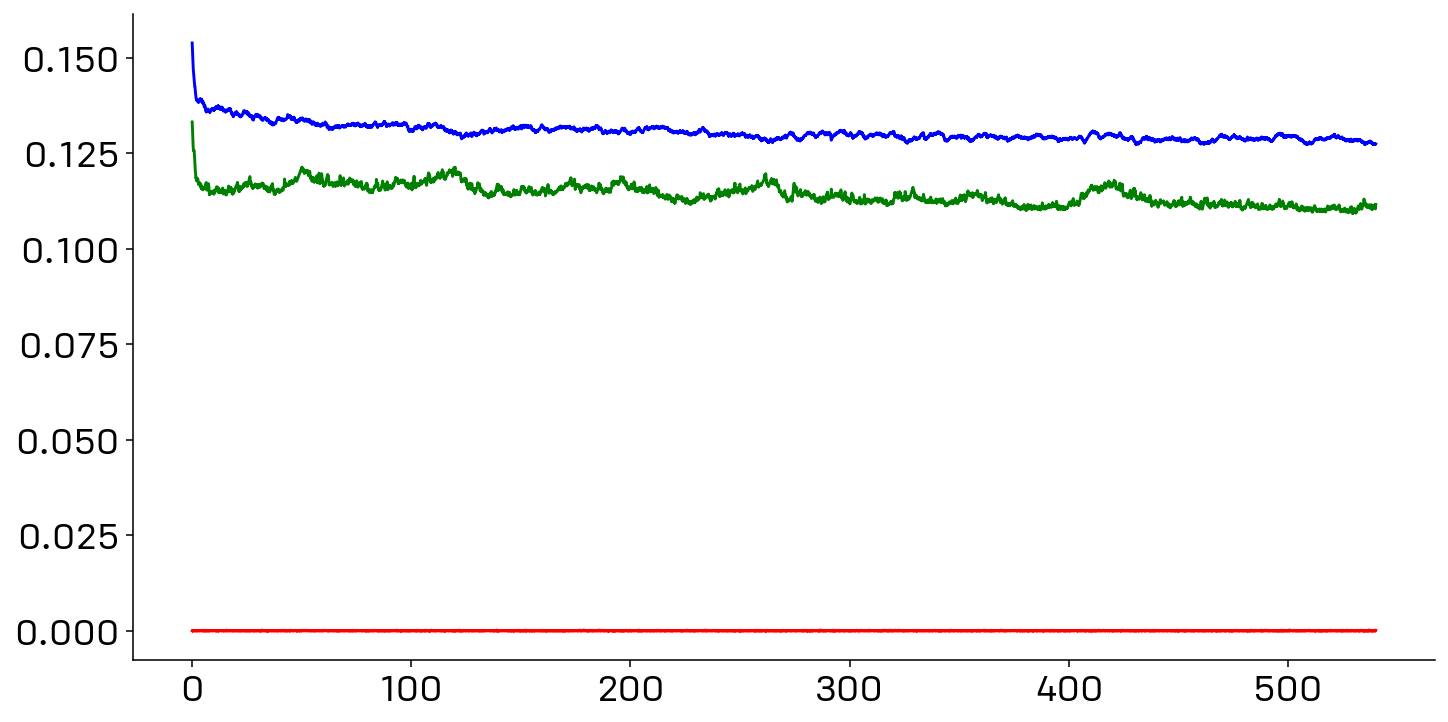

In [46]:
## NOISE CORRECTION 
sampling_rate = 60

b,a = butter(2, 10, btype='low', fs=sampling_rate)
gcamp_denoised = filtfilt(b,a, resampled_gcamp)
iso_denoised = filtfilt(b,a, resampled_iso)
rcamp_denoised = filtfilt(b, a, resampled_rcamp)


##NOISE CORRECTION  PLOT
plt.figure(figsize=(12, 6))
plt.plot(time, gcamp_denoised, color='g', label='Smoothed FP Zscore (Savitzky-Golay)')
plt.plot(time, iso_denoised, color='b')
plt.plot(time, rcamp_denoised, color='r')
#ax2.set_ylim(0.6, 1.2)

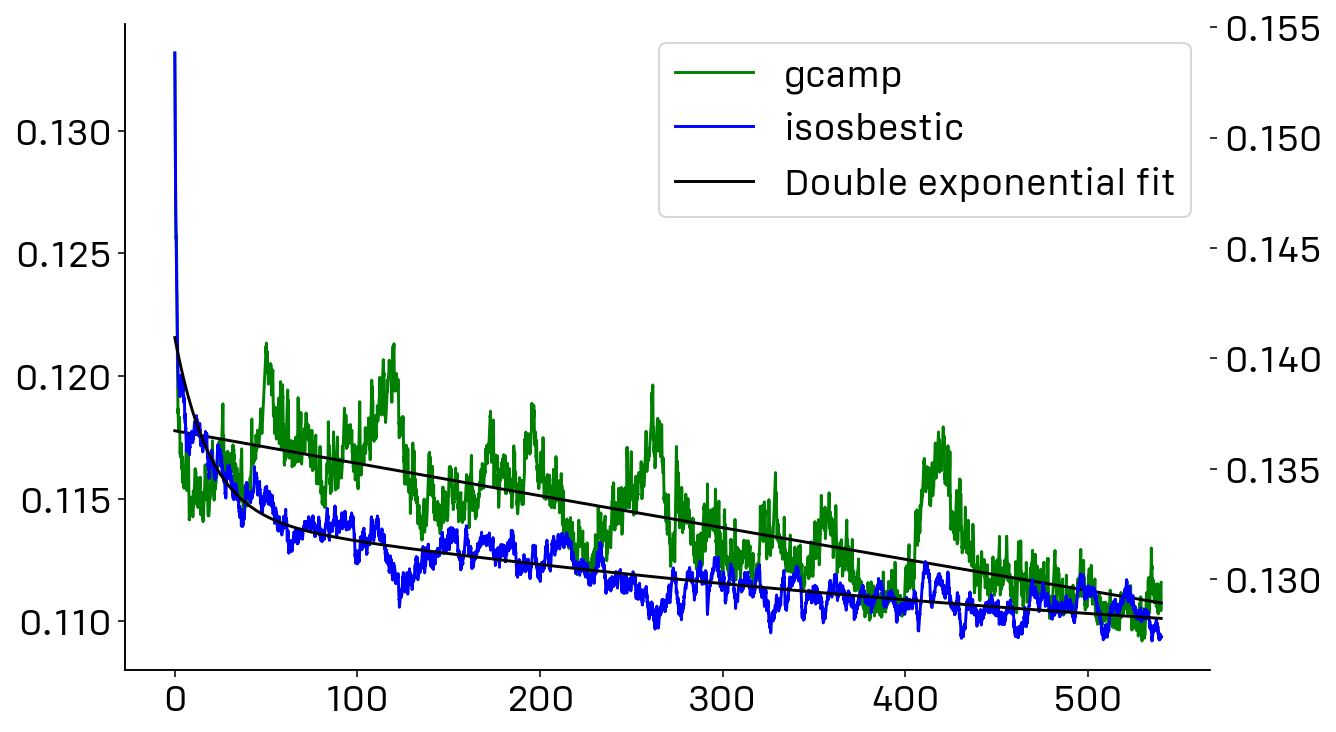

In [47]:
## PHOTOBLEACHING CORRECTION -> Maybe fit only on baseline periods and apply it to everything? 
#Using double exponential fit  

def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):

    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

## Fitting exp to signal 
#Gcamp
max_sig = np.max(gcamp_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
gcamp_params, parm_cov = curve_fit(double_exponential, time, gcamp_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares optimization
gcamp_expfit = double_exponential(time, *gcamp_params)

#Isosbestic
max_sig = np.max(iso_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
iso_params, parm_cov = curve_fit(double_exponential, time, iso_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares 
iso_expfit = double_exponential(time, *iso_params)

#Rcamp
max_sig = np.max(rcamp_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
rcamp_params, parm_cov = curve_fit(double_exponential, time, rcamp_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares 
rcamp_expfit = double_exponential(time, *rcamp_params)

##PLOTS 

fig,ax1=plt.subplots(figsize=(10,6))  

plot1=ax1.plot(time, gcamp_denoised, 'g', label='gcamp')
plot3=ax1.plot(time, gcamp_expfit, color='k', linewidth=1.5, label='Double exponential fit') 
ax2=plt.twinx()
plot2=ax2.plot(time, iso_denoised, color='b', label='isosbestic') 
plot4=ax2.plot(time, iso_expfit,color='k', linewidth=1.5) 

lines = plot1 + plot2 + plot3
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels); 


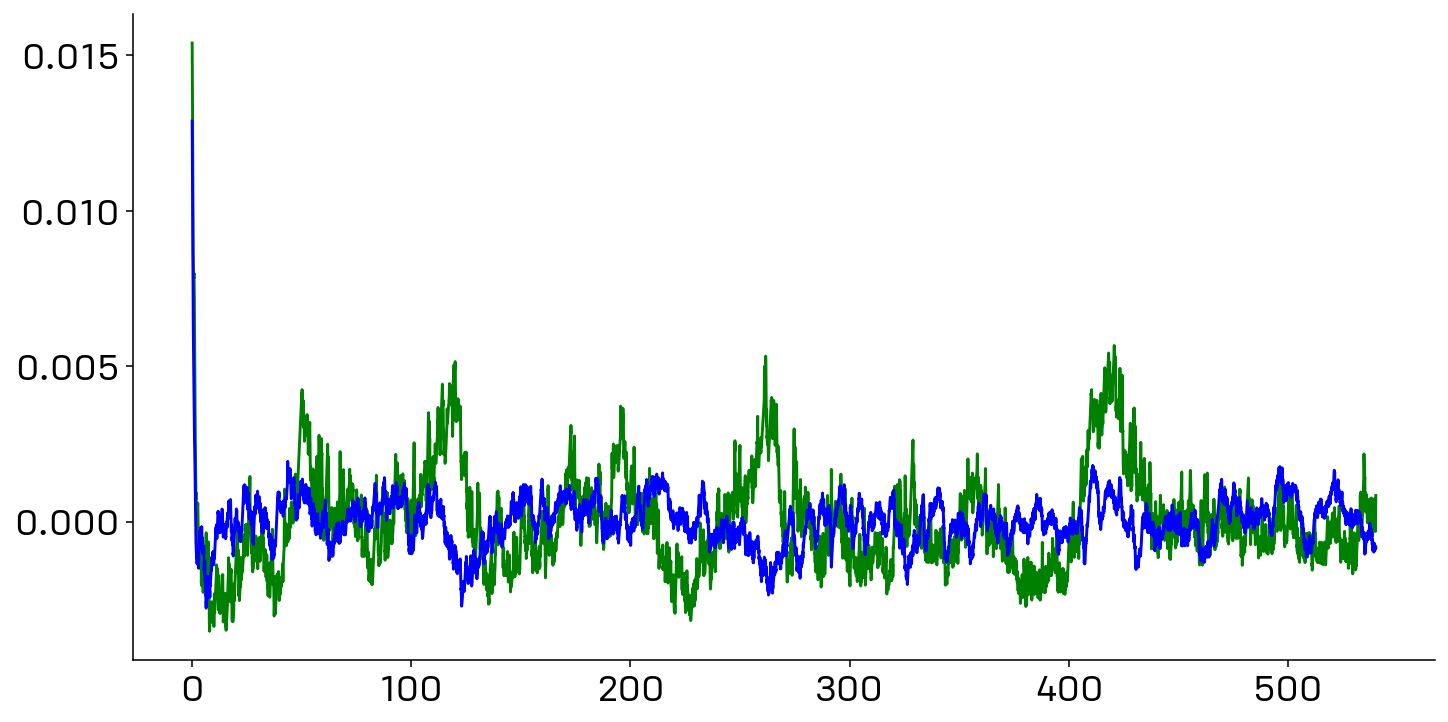

In [48]:
##PHOTOBLEACHING FREE PLOT
gcamp_detrended = gcamp_denoised - gcamp_expfit
iso_detrended = iso_denoised - iso_expfit
rcamp_detrended = rcamp_denoised - rcamp_expfit

plt.figure(figsize=(12, 6))
plt.plot(time, gcamp_detrended, color='g')
plt.plot(time, iso_detrended, color='b')



(0.0, 5.0)

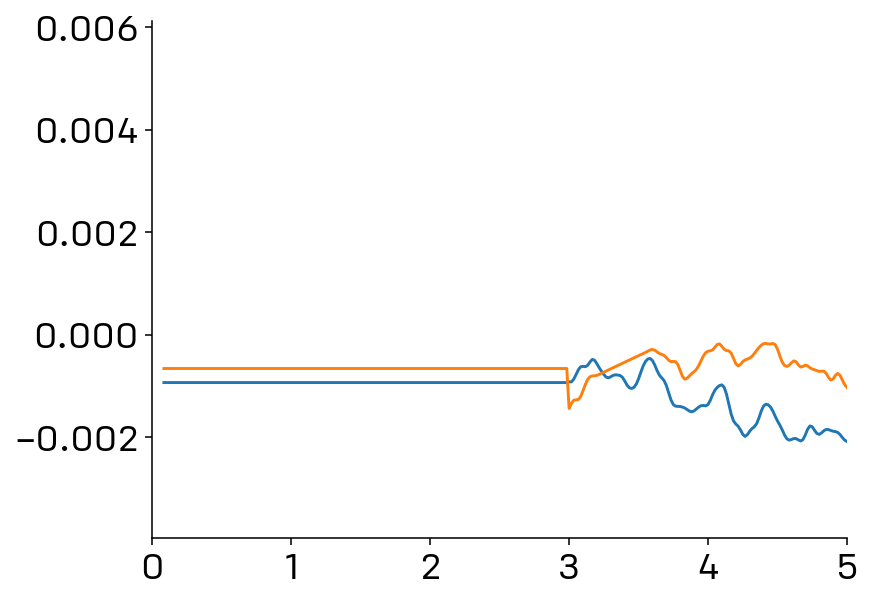

In [49]:
##WHEN TOO MUCH SIGNAL, just take out the first 3 seconds to not fuck up dff
# Find indices for the 3rd second (from 2 to 3 seconds)
indices_3_sec = (time >= 3) & (time < 4)

# Calculate the average values in the 3rd second
gcamp_3_sec_avg = np.mean(gcamp_detrended[indices_3_sec])
iso_3_sec_avg = np.mean(iso_detrended[indices_3_sec])
rcamp_3_sec_avg = np.mean(rcamp_detrended[indices_3_sec])

# Find the indices for the first 2 seconds
indices_2_sec = time < 3

# Set the first 2 seconds to the 3-second average value
gcamp_detrended[indices_2_sec] = gcamp_3_sec_avg
iso_detrended[indices_2_sec] = iso_3_sec_avg
rcamp_detrended[indices_2_sec] = rcamp_3_sec_avg

# Plot results

plt.plot(time, gcamp_detrended)
plt.plot(time, iso_detrended)
plt.xlim(0,5)



Slope    : 0.050
R-squared: 0.001


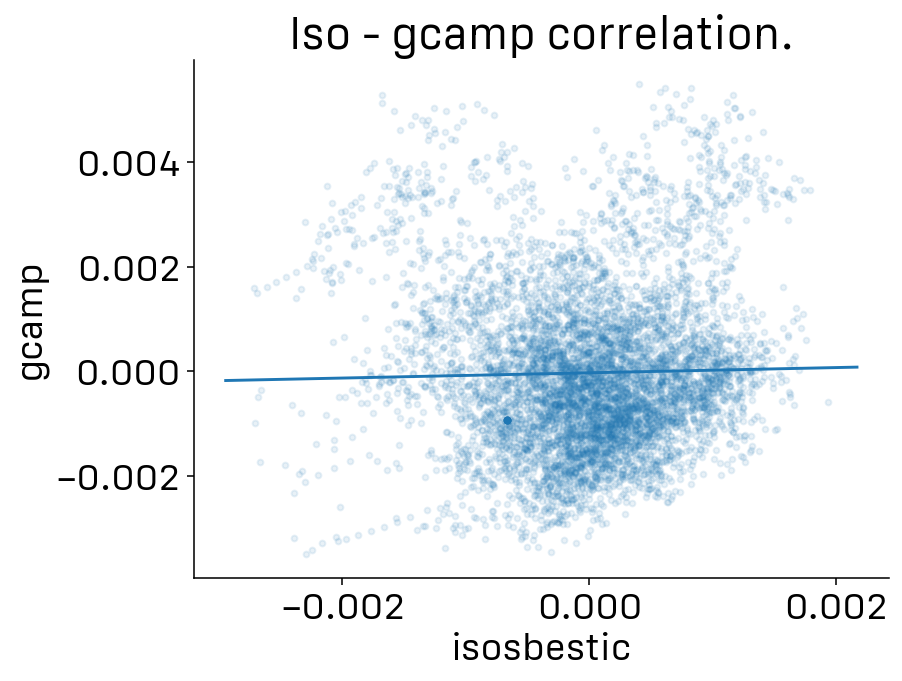

In [50]:
##REMOVING MOVEMENT ARTIFACTS 
##Using linear regression to fit iso to gcamp

slope, intercept, r_value, p_value, std_err = linregress(x=iso_detrended, y=gcamp_detrended) #get regression parameters 

plt.scatter(iso_detrended[::5], gcamp_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x) #Plot the regression line 
plt.xlabel('isosbestic')
plt.ylabel('gcamp')
plt.title('Iso - gcamp correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))


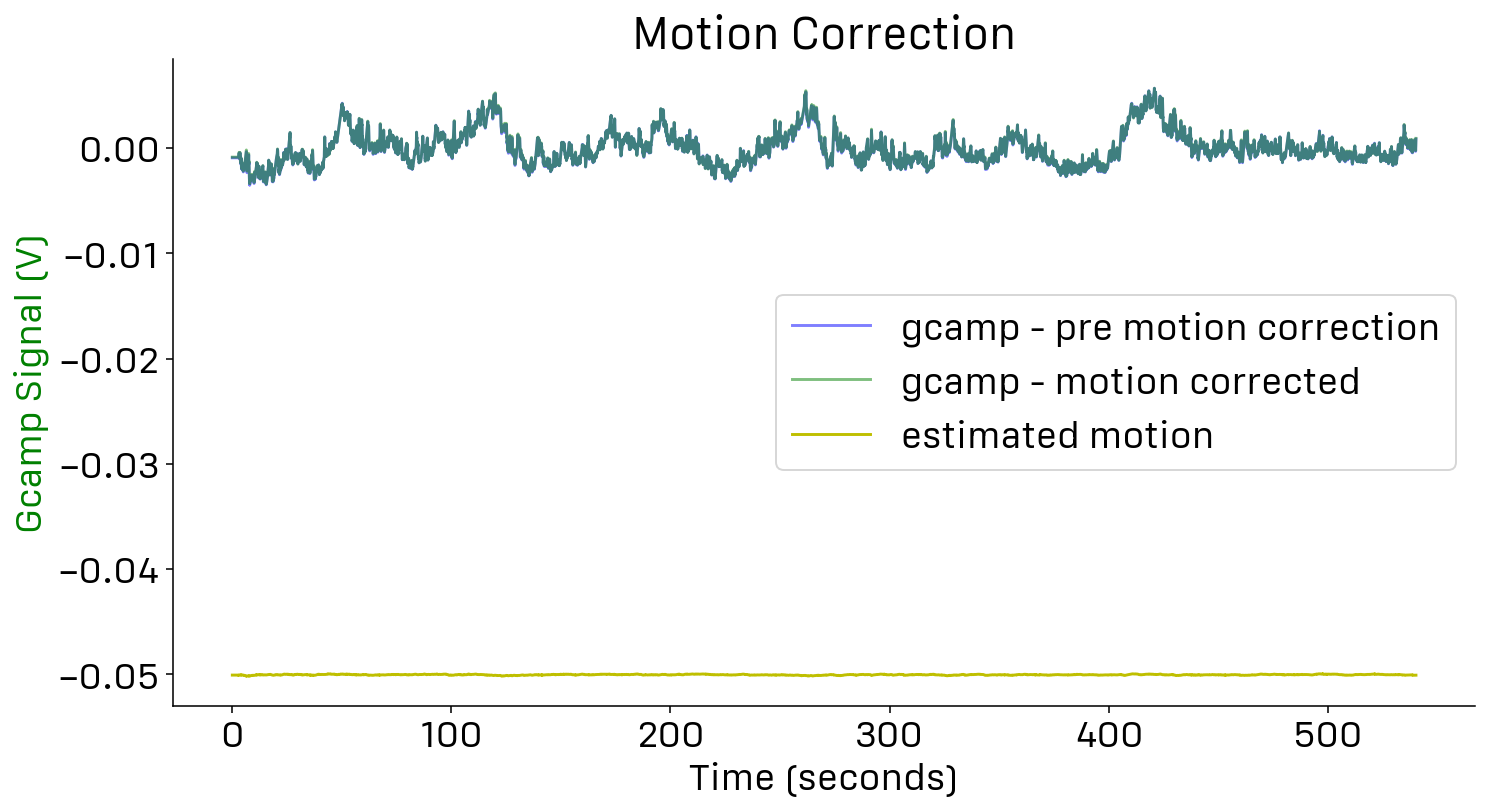

In [51]:
##SUBSTRACTING ESTIMATED MOTION 

gcamp_est_motion = intercept + slope * iso_detrended
gcamp_corrected = gcamp_detrended - gcamp_est_motion

fig,ax1=plt.subplots(figsize=(12,6))  
plot1=ax1.plot(time, gcamp_detrended, 'b' , label='gcamp - pre motion correction', alpha=0.5)
plot3=ax1.plot(time, gcamp_corrected, 'g', label='gcamp - motion corrected', alpha=0.5)
plot4=ax1.plot(time, gcamp_est_motion - 0.05, 'y', label='estimated motion')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Gcamp Signal (V)', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels)

#ax1.set_xlim(0, 460)  # 60 sec window
#ax1.set_ylim(-0.075, 0.1)

Slope    : 0.001
R-squared: 0.001


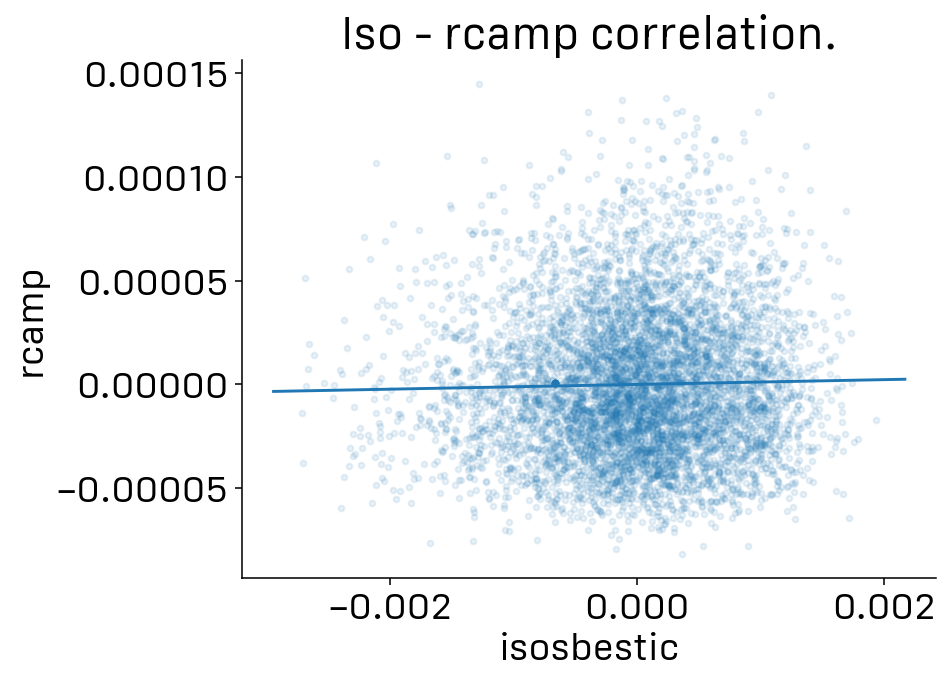

In [52]:
##REMOVING MOVEMENT ARTIFACTS RCAMP 
##Using linear regression to fit iso to gcamp

slope, intercept, r_value, p_value, std_err = linregress(x=iso_detrended, y=rcamp_detrended) #get regression parameters 

plt.scatter(iso_detrended[::5], rcamp_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x) #Plot the regression line 
plt.xlabel('isosbestic')
plt.ylabel('rcamp')
plt.title('Iso - rcamp correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))


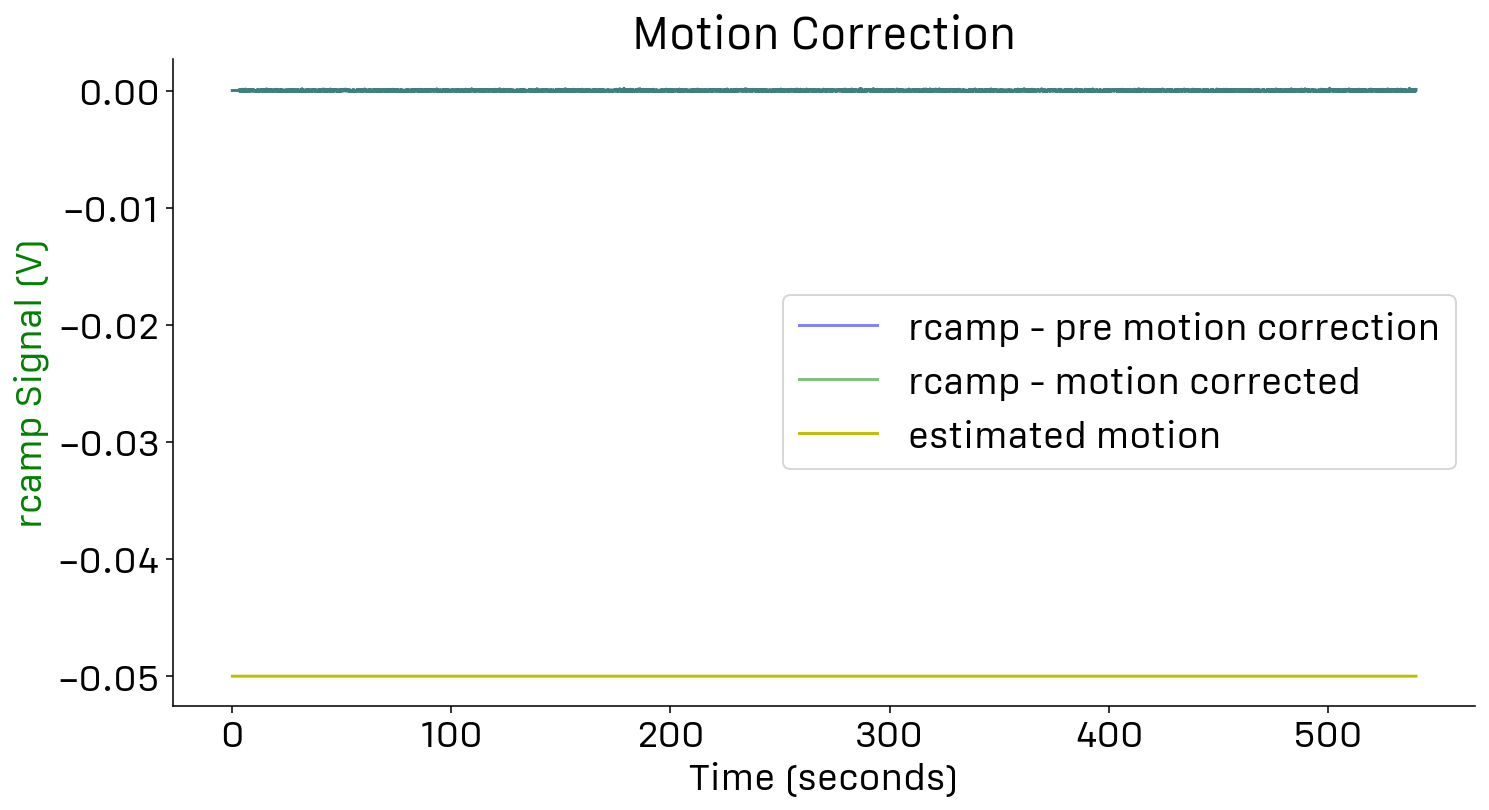

In [53]:
##SUBSTRACTING ESTIMATED MOTION RCAMP 

rcamp_est_motion = intercept + slope * iso_detrended
rcamp_corrected = rcamp_detrended - rcamp_est_motion

fig,ax1=plt.subplots(figsize=(12,6))  
plot1=ax1.plot(time, rcamp_detrended, 'b' , label='rcamp - pre motion correction', alpha=0.5)
plot3=ax1.plot(time, rcamp_corrected, 'g', label='rcamp - motion corrected', alpha=0.5)
plot4=ax1.plot(time, rcamp_est_motion - 0.05, 'y', label='estimated motion')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('rcamp Signal (V)', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels)

# ax1.set_xlim(110, 180)  # 60 sec window
#ax1.set_ylim(-0.075, 0.1)

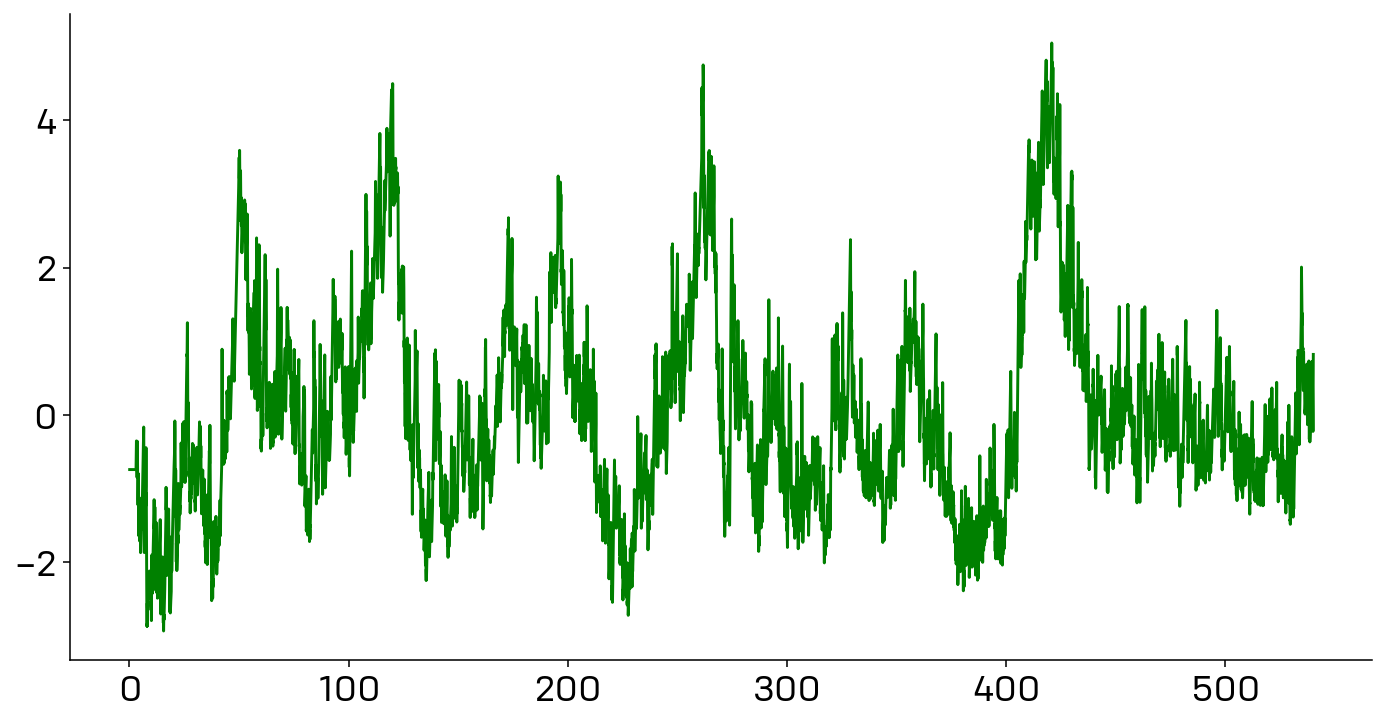

In [54]:
### NORMALIZATION : DF/F
dffg=100*gcamp_corrected/gcamp_expfit
dffr=100*rcamp_corrected/rcamp_expfit

plt.figure(figsize=(12, 6))
plt.plot(time, dffg, color='g')
#plt.plot(time, dffr, color='r')
# plt.plot(time, rcamp_est_motion, color='b')
# plt.xlim(250, 360)
#ax1.set_ylim(-3, 3)

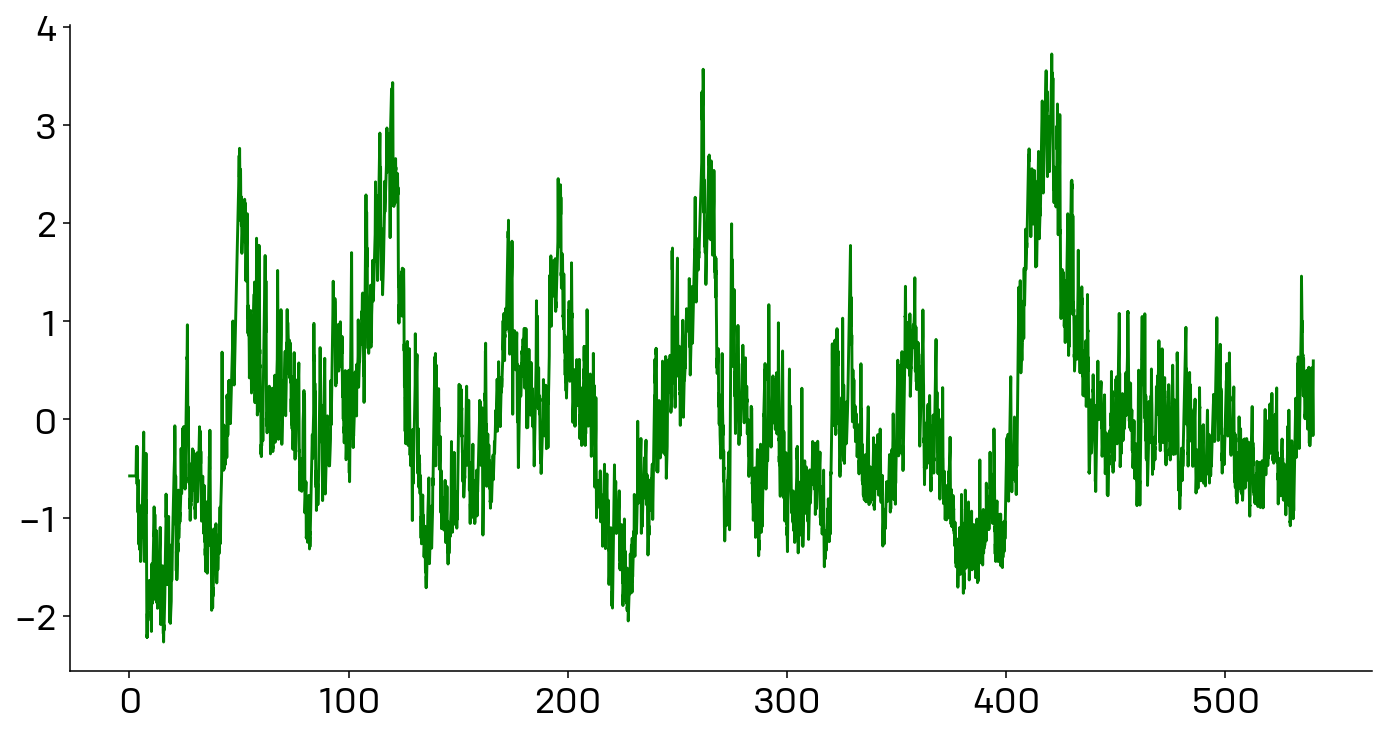

In [55]:
## Normalization : Z-Scoring 
zscoreg = (gcamp_corrected-np.mean(gcamp_corrected))/np.std(gcamp_corrected)
zscorer = (rcamp_corrected-np.mean(rcamp_corrected))/np.std(rcamp_corrected)

plt.figure(figsize=(12, 6))
plt.plot(time, zscoreg, color='g')
# plt.plot(time, zscorer, color='r')


#plt.xlim(450, 460)
#ax1.set_ylim(-3, 3);

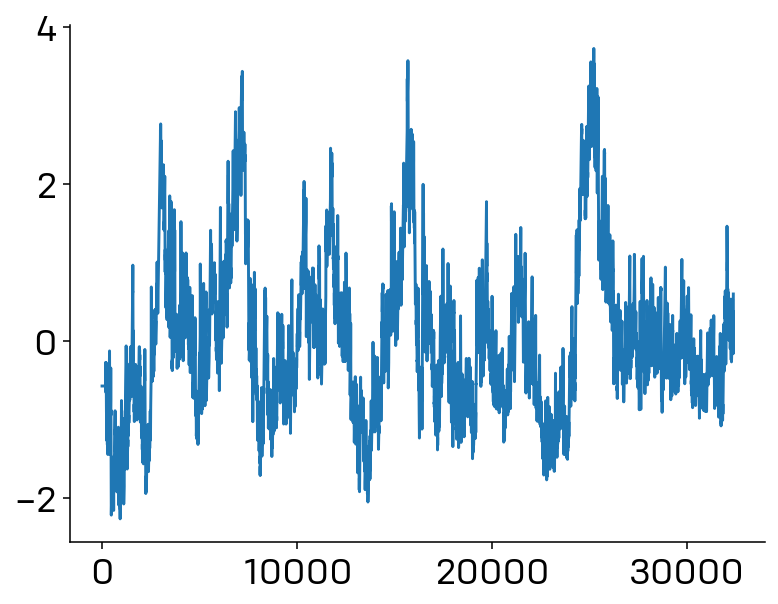

In [56]:
## SMOOTHING
from scipy.signal import savgol_filter


polyorder = 2  # Polynomial order
window_length = 181  # Window length: must be an odd number

# Apply the filter
zscore = savgol_filter(zscoreg, window_length, polyorder)

plt.plot(zscoreg)

In [57]:
###Convert preprocessed traces as df for easier manipulation

fp_df = pd.DataFrame({'Time': time, 'Zscoreg': zscoreg, 'Zscorer' : zscorer})
fp_df

,Time,Zscoreg,Zscorer
0,0.083083,-0.575240,0.045613
1,0.099755,-0.575240,0.045613
2,0.116428,-0.575240,0.045613
3,0.133100,-0.575240,0.045613
4,0.149772,-0.575240,0.045613
...,...,...,...
32387,540.047522,0.404075,-0.926126
32388,540.064194,0.450131,-0.456854
32389,540.080866,0.485865,0.714289
32390,540.097538,0.534747,1.908231


In [58]:
# count NA at start as 0 
ampos['Centre position X'] = ampos['Centre position X'].fillna(0)
ampos['Centre position Y'] = ampos['Centre position Y'].fillna(0)

#Create time bins and put them into main df
time_bins = ampos['Time (s)'].values  # Use ampos time as bin edges
time_bins = np.append(time_bins, time_bins[-1] + (time_bins[-1] - time_bins[-2]))  # Add an extra bin edge to cover all data
fp_df['Time_bin'] = pd.cut(fp_df['Time'], bins=time_bins, labels=time_bins[:-1], include_lowest=True)

# Average Zscore for each bin
binned_zscoreg = fp_df.groupby('Time_bin')['Zscoreg'].mean().reset_index()
binned_zscoreg.rename(columns={'Time_bin': 'Time (s)'}, inplace=True)

binned_zscoreg['Zscoreg'] = (binned_zscoreg['Zscoreg'] - binned_zscoreg['Zscoreg'].min()) / (binned_zscoreg['Zscoreg'].max() - binned_zscoreg['Zscoreg'].min())
ampos2 = ampos.merge(binned_zscoreg, on='Time (s)', how='left')
np.max(ampos2['Zscoreg'])
print(ampos2)

      Time (s)  Centre position X  Centre position Y   Zscoreg
0          0.0                0.0                0.0  0.282162
1        0.369              568.1              353.6  0.282162
2        0.433              578.3              358.7  0.282162
3        0.464              582.1              360.0  0.282162
4        0.497              587.2              362.6  0.282162
...        ...                ...                ...       ...
14846  499.488              385.5              251.5  0.310086
14847  499.536              385.5              251.5  0.316344
14848  499.568              385.5              251.5  0.320221
14849    499.6              385.5              251.5  0.323694
14850  499.632              385.5              251.5  0.327821

[14851 rows x 4 columns]


/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_85514/2353678470.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_zscoreg = fp_df.groupby('Time_bin')['Zscoreg'].mean().reset_index()


In [59]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import numpy as np

# # Parameters for the cross
# cross_size = 420  # Size of the cross in mm
# center_x = 295    # Center position X
# center_y = 235    # Center position Y

# # Create figure and axis
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.set_xlim(0, 550)
# ax.set_ylim(0, 550)
# ax.set_aspect('equal', adjustable='box')
# ax.axis('off')  # Turn off axis visibility

# # Add the cross to the plot
# ax.plot(
#     [center_x - cross_size / 2, center_x + cross_size / 2], 
#     [center_y, center_y], color='black', lw=22, zorder=1)
# ax.plot(
#     [center_x, center_x], 
#     [center_y - cross_size / 2, center_y + cross_size / 2], 
#     color='black', lw=25, zorder=1)
# ax.plot(
#     [center_x - cross_size / 2, center_x + cross_size / 2], 
#     [center_y, center_y], color='white', lw=21, zorder=2)
# ax.plot(
#     [center_x, center_x], 
#     [center_y - cross_size / 2, center_y + cross_size / 2], 
#     color='white', lw=21, zorder=2)

# # Initialize scatter plot
# scatter = ax.scatter([], [], c=[], cmap='inferno', alpha=1, zorder=3,s=100)

# # Colorbar
# cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04, shrink=0.7)
# cbar.set_label('Normalized Z-Score')

# # Animation update function
# def update(frame):
#     # Plot the scatter point for the current frame
#     scatter.set_offsets([[ampos2.iloc[frame]['Centre position X'], ampos2.iloc[frame]['Centre position Y']]])
#     scatter.set_array(np.array([ampos2.iloc[frame]['Zscoreg']]))
#     return scatter,

# # Create the animation
# ani = animation.FuncAnimation(
#     fig, update, frames=len(ampos2), interval=300, blit=True)  # interval in ms

# # Save animation as video
# ani.save('mouse_position_zscore1035.gif', writer='pillow', fps=60)
# plt.show()


/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_85514/1509274660.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spatial_avg = ampos2.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()


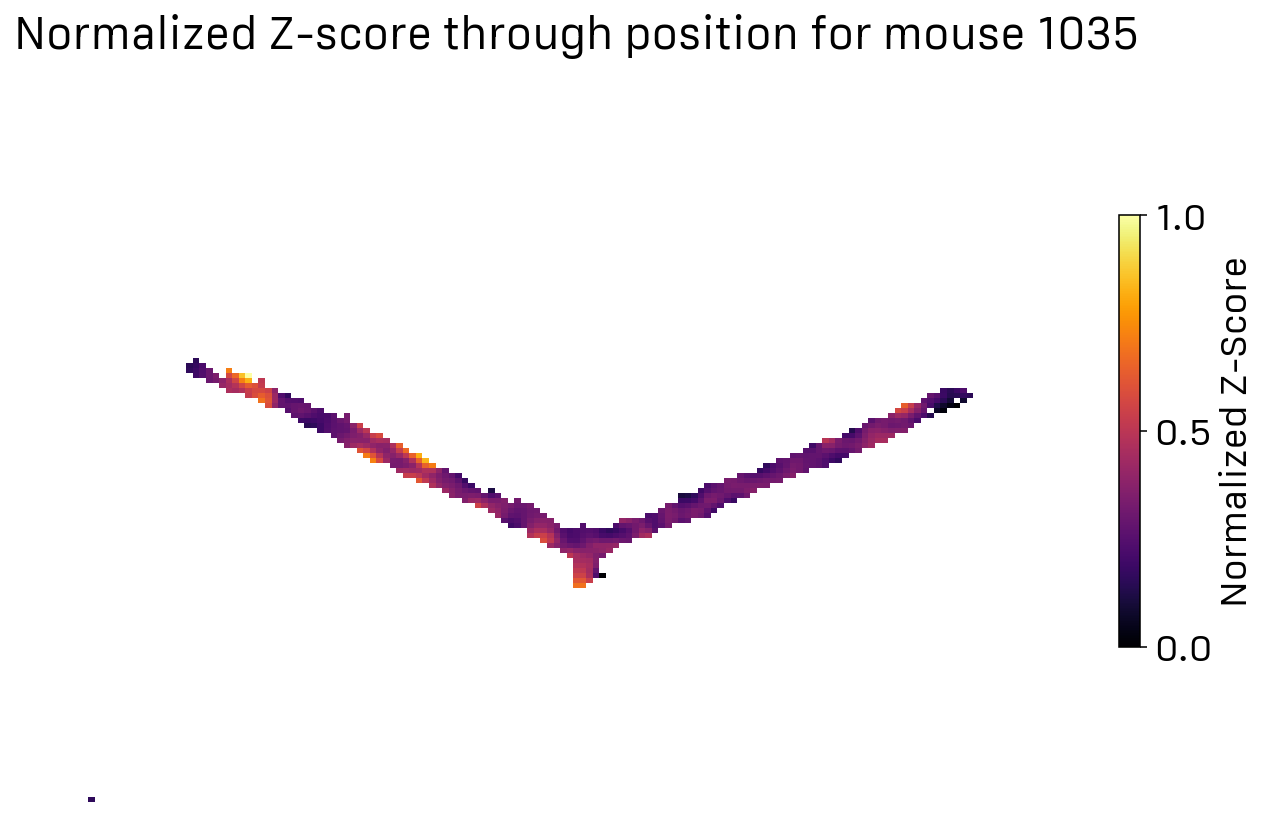

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import convolve

# Create a copy to preserve the original dataset
ampos2 = ampos.copy()

# Drop rows with NaN values in 'Centre position X' and 'Centre position Y'
ampos2 = ampos2.dropna(subset=['Centre position X', 'Centre position Y'])

# Define 1 cm bins for spatial positions
bin_size = 5  # cm
x_bins = np.arange(0, 750, bin_size)
y_bins = np.arange(0, 750, bin_size)

# Assign data to spatial bins
ampos2['X_bin'] = pd.cut(ampos2['Centre position X'], bins=x_bins, labels=x_bins[:-1], include_lowest=True)
ampos2['Y_bin'] = pd.cut(ampos2['Centre position Y'], bins=y_bins, labels=y_bins[:-1], include_lowest=True)

# Merge the Zscoreg data back into ampos2
ampos2 = ampos2.merge(binned_zscoreg, on='Time (s)', how='left')

# Group by spatial bins and compute the mean Zscoreg
spatial_avg = ampos2.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()

# Convert bins to numeric for heatmap plotting
spatial_avg['X_bin'] = spatial_avg['X_bin'].astype(float)
spatial_avg['Y_bin'] = spatial_avg['Y_bin'].astype(float)

# Pivot the table to create a 2D array for the heatmap
heatmap_data = spatial_avg.pivot(index='Y_bin', columns='X_bin', values='Zscoreg')

# Fill missing values with NaN instead of 0
heatmap_data = heatmap_data.fillna(np.nan)

# Create a quasi-Gaussian kernel for 5×5 bins
kernel_size = 5
sigma = 1.0
x = np.linspace(-2, 2, kernel_size)
y = np.linspace(-2, 2, kernel_size)
x, y = np.meshgrid(x, y)
kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
kernel /= np.sum(kernel)  # Normalize the kernel

# Apply the kernel to smooth the heatmap
masked_data = np.nan_to_num(heatmap_data, nan=0)
mask = ~np.isnan(heatmap_data)

# Convolve with the kernel
smoothed_data = convolve(masked_data, kernel, mode='constant', cval=0.0)
smoothed_mask = convolve(mask.astype(float), kernel, mode='constant', cval=0.0)
smoothed_data /= np.maximum(smoothed_mask, 1e-10)  # Avoid division by zero
smoothed_data[~mask] = np.nan  # Restore NaN values

# Normalize smoothed data
smoothed_data = (smoothed_data - np.nanmin(smoothed_data)) / (np.nanmax(smoothed_data) - np.nanmin(smoothed_data))

# Plot the smoothed heatmap
plt.figure(figsize=(10, 8))
plt.imshow(smoothed_data, cmap='inferno', extent=[0, 750, 0, 570], origin='lower', interpolation='none', zorder=3)

# Customize plot
cbar = plt.colorbar(label='Normalized Z-Score', shrink=0.5, fraction=0.05)
cbar.set_ticks([0, 0.5, 1])
plt.xlabel('Centre Position X (mm)')
plt.ylabel('Centre Position Y (mm)')
plt.title(f'Normalized Z-score through position for mouse {mouse_id}')


plt.gca().set_aspect('equal', adjustable='box')
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

#plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/NOR_BLA/figures/smoothed_heatmap{mouse_id}.pdf', format='pdf')
plt.show()

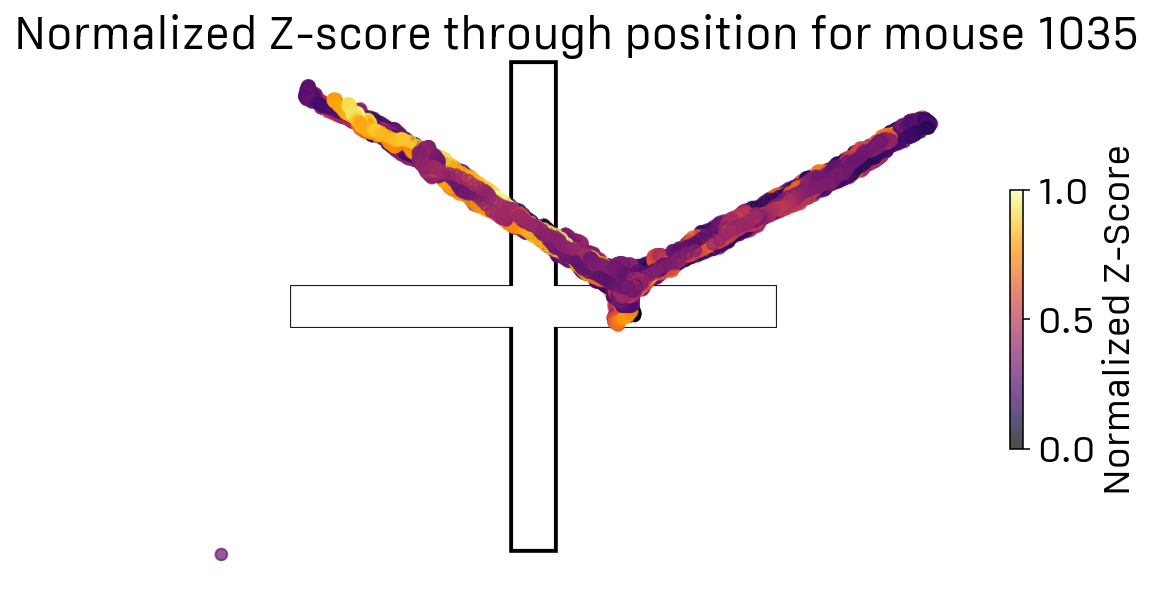

In [61]:
# plot the shit
plt.figure(figsize=(8, 8))

# Plot the scatter plot first
scatter = plt.scatter(
    ampos2['Centre position X'], 
    ampos2['Centre position Y'], 
    c=ampos2['Zscoreg'], 
    cmap='inferno',
    alpha=0.7,
    zorder=3)

# Now, plot the cross in the background by drawing after the scatter
cross_size = 420  # Size of the cross in mm
center_x = 295    # Center position X
center_y = 235   # Center position Y

# Add the cross in the background (horizontal and vertical lines)
plt.plot([center_x - cross_size / 2, center_x + cross_size / 2], [center_y, center_y], color='black', lw=22)  # horizontal line
plt.plot([center_x, center_x], [center_y - cross_size / 2, center_y + cross_size / 2], color='black', lw=25)  # vertical line
plt.plot([center_x - cross_size / 2, center_x + cross_size / 2], 
         [center_y, center_y], color='white', lw=21, zorder=2)
plt.plot([center_x, center_x], 
         [center_y - cross_size / 2, center_y + cross_size / 2], 
         color='white', lw=21, zorder=2)

plt.colorbar(scatter, label='Normalized Z-Score', shrink=0.3, fraction=0.05)
plt.xlabel('Centre Position X (mm)')
plt.ylabel('Centre Position Y (mm)')
plt.title(f'Normalized Z-score through position for mouse {mouse_id}')
# plt.xlim(0, 550) # Set background color to black
# plt.ylim(0, 550)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

In [62]:
#GET EVENTS FROM ANYMAZE DF

# Initialize a dictionary to store events for each behavior
all_events = {col: {'start': [], 'end': []} for col in TTL_an.columns if col != 'Time (s)'}

# Function to extract start and end events for each behavior
def extract_events(TTL_an):
    for col in all_events.keys():
        sound_on = False
        start_time = None  # Initialize start_time
        
        for i in range(len(TTL_an)):
            if TTL_an[col].iloc[i] == 1:
                if not sound_on:  # Event starts
                    start_time = TTL_an['Time (s)'].iloc[i]
                    sound_on = True
            elif TTL_an[col].iloc[i] == 0:
                if sound_on:  # Event stops
                    end_time = TTL_an['Time (s)'].iloc[i]
                    all_events[col]['start'].append(start_time)
                    all_events[col]['end'].append(end_time)
                    sound_on = False

        # Handle the case where the signal ends with 1
        if sound_on:
            end_time = 600  # WORKS ONLY WITH THIS CONFIGURATION
            all_events[col]['start'].append(start_time)
            all_events[col]['end'].append(end_time)

# Run the function
extract_events(TTL_an)


# Convert each behavior's event data to DataFrames
df_events = {col: pd.DataFrame(data) for col, data in all_events.items()}

# Print each DataFrame for each behavior
for behavior, df in df_events.items():
    print(f"Events for {behavior}:")
    print(df)
    print("\n")

# Output the main events dictionary if needed
#print(df_events.items)


Events for Investigating familiarobject:
      start      end
0     0.528    1.088
1    10.256   11.201
2    22.896   23.232
3    51.856   52.337
4    52.801   55.729
5    56.657   57.088
6    57.664   57.888
7    83.297   85.088
8    85.697   87.089
9   146.464  150.000
10  165.200  167.329
11  169.361  170.224
12  173.792  173.888
13  175.792  176.224
14  176.432  178.768
15  185.824  189.201
16  225.568  227.360
17  230.833  232.033
18  233.569  234.337
19  236.001  236.336
20  244.928  249.265
21  259.456  262.737
22  385.888  389.488
23  428.528  430.864
24  464.992  467.200


Events for Investigating novelobject:
      start      end
0     4.128    5.536
1    17.089   18.001
2    43.168   46.560
3    67.265   67.536
4    67.728   68.160
5    97.937   99.201
6    99.568   99.600
7   100.401  100.769
8   100.864  101.457
9   200.688  201.728
10  202.769  203.264
11  203.489  204.128
12  204.592  207.136
13  207.296  207.792
14  209.536  209.633
15  275.088  276.288
16  372.496  374

In [63]:
# Add behavior columns to the main DataFrame
for behavior, df in df_events.items():
    # Initialize the behavior column with zeros
    fp_df[behavior] = 0
    
    # Iterate through each start and end time for the behavior
    for start, end in zip(df['start'], df['end']):
        # Set the behavior column to 1 for rows within the start-end interval
        fp_df.loc[(fp_df['Time'] >= start) & (fp_df['Time'] <= end), behavior] = 1

fp_df = fp_df.drop(columns=['Time_bin'])

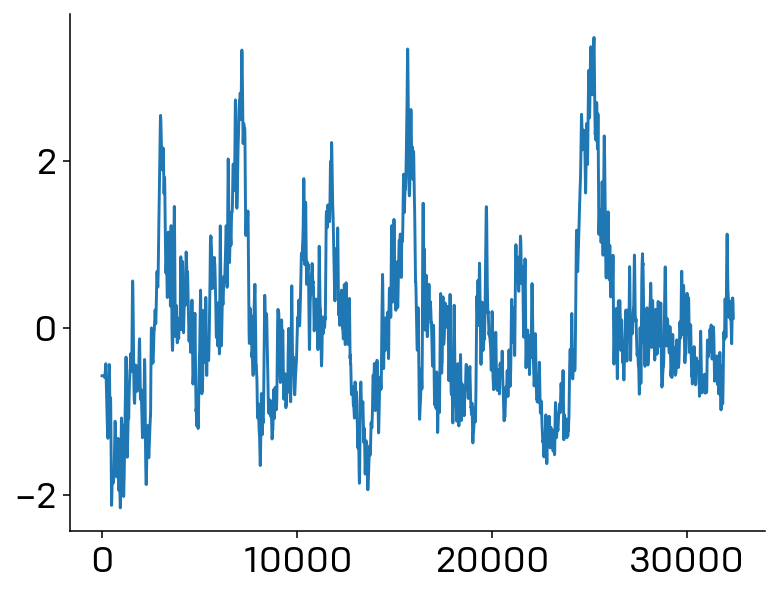

In [64]:
## SMOOTHING extreme smoothing for whole trace representative


polyorder = 2  # Polynomial order
window_length = 81  # Window length: must be an odd number

# Apply the filter
fp_df['Zscoreg'] = savgol_filter(fp_df['Zscoreg'], window_length, polyorder)

plt.plot(fp_df['Zscoreg'])

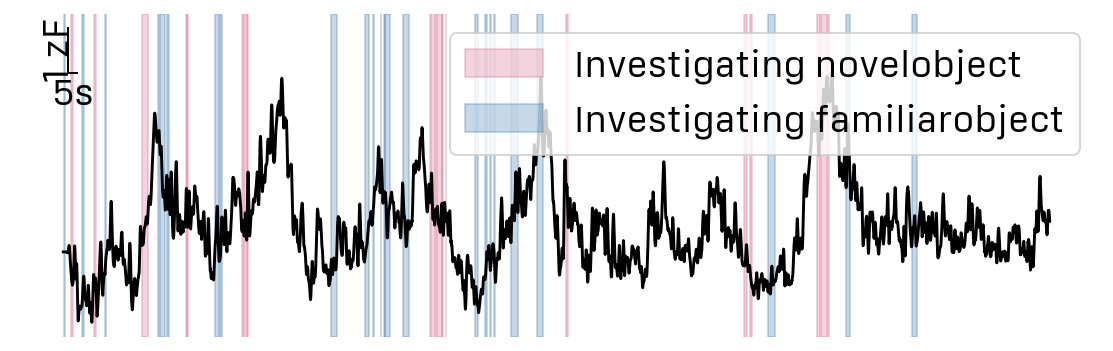

In [65]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create the plot
fig, ax = plt.subplots(figsize=(10, 3))

# Plot Zscoreg through Time
ax.plot(fp_df['Time'], fp_df['Zscoreg'], color='black')

# Define colors for events
behavior_columns = ['Investigating novelobject', 'Investigating familiarobject']
colors = ['palevioletred', 'steelblue']  # Use a colormap for unique colors

# Add shaded regions for each behavior
for color, behavior in zip(colors, behavior_columns):
    # Find time intervals where the behavior occurs
    starts = fp_df.loc[fp_df[behavior].diff() == 1, 'Time']
    ends = fp_df.loc[fp_df[behavior].diff() == -1, 'Time']
    
    # Handle case where behavior starts at the first row
    if not fp_df.empty and fp_df[behavior].iloc[0] == 1:
        starts = pd.concat([pd.Series(fp_df['Time'].iloc[0]), starts])
    # Handle case where behavior ends at the last row
    if not fp_df.empty and fp_df[behavior].iloc[-1] == 1:
        ends = pd.concat([ends, pd.Series(fp_df['Time'].iloc[-1])])
    
    # Add shaded regions with the assigned color
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, alpha=0.3, label=behavior, color=color)

# Customize the plot

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

y_min, y_max = plt.gca().get_ylim()  # Get current y-axis limits
x_min, x_max = plt.gca().get_xlim()  # Get current x-axis limits
scale_x_pos = x_min + (x_max - x_min) * 0.05  # Position to the left of the plot
scale_y_pos = y_max - (y_max - y_min) * 0.05  # Position near the top of the plot

plt.plot([scale_x_pos, scale_x_pos], [scale_y_pos, scale_y_pos + 1], color='black', linewidth=1)
plt.text(scale_x_pos - 5, scale_y_pos + 0.5, '1 zF', ha='center', va='center', rotation='vertical')

plt.plot([scale_x_pos, scale_x_pos + 5], [scale_y_pos, scale_y_pos], color='black', linewidth=1)  # Horizontal line at y=0
plt.text(scale_x_pos + 2.5, scale_y_pos - 0.1, '5s', ha='center', va='top')

#drop the y axis
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
#Create one legend entry per event
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates
ax.legend(by_label.values(), by_label.keys(), loc='upper right')
# plt.xlim(0,100)
# plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/NOR_BLA/figures/fullrecording{mouse_id}.pdf', format='pdf')
plt.show()

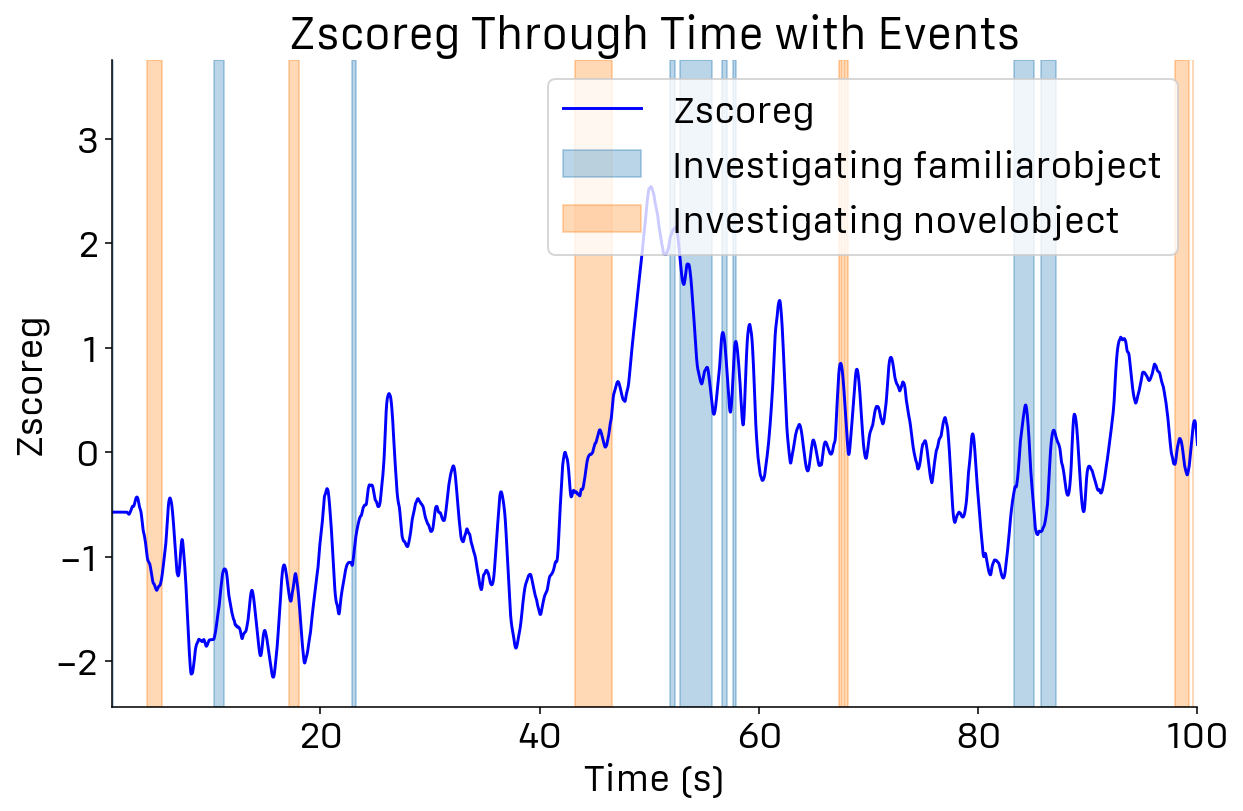

In [66]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Zscoreg through Time
ax.plot(fp_df['Time'], fp_df['Zscoreg'], label='Zscoreg', color='blue')

# Define colors for events
behavior_columns = ['Investigating familiarobject', 'Investigating novelobject']
colors = cm.tab10(range(len(behavior_columns)))  # Use a colormap for unique colors

# Add shaded regions for each behavior
for color, behavior in zip(colors, behavior_columns):
    # Find time intervals where the behavior occurs
    starts = fp_df.loc[fp_df[behavior].diff() == 1, 'Time']
    ends = fp_df.loc[fp_df[behavior].diff() == -1, 'Time']
    
    # Handle case where behavior starts at the first row
    if not fp_df.empty and fp_df[behavior].iloc[0] == 1:
        starts = pd.concat([pd.Series(fp_df['Time'].iloc[0]), starts])
    # Handle case where behavior ends at the last row
    if not fp_df.empty and fp_df[behavior].iloc[-1] == 1:
        ends = pd.concat([ends, pd.Series(fp_df['Time'].iloc[-1])])
    
    # Add shaded regions with the assigned color
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, alpha=0.3, label=behavior, color=color)

# Customize the plot
ax.set_title("Zscoreg Through Time with Events")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Zscoreg")

# Create one legend entry per event
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates
ax.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.xlim(1, 100)
plt.show()


In [67]:
#add mouse ID, sex and day of experiment(if needed)

fp_df['ID']=mouse_id
fp_df['sex']=sex
fp_df

,Time,Zscoreg,Zscorer,Investigating familiarobject,Investigating novelobject,ID,sex
0,0.083083,-0.575240,0.045613,0,0,1035,M
1,0.099755,-0.575240,0.045613,0,0,1035,M
2,0.116428,-0.575240,0.045613,0,0,1035,M
3,0.133100,-0.575240,0.045613,0,0,1035,M
4,0.149772,-0.575240,0.045613,0,0,1035,M
...,...,...,...,...,...,...,...
32387,540.047522,0.170053,-0.926126,0,0,1035,M
32388,540.064194,0.156764,-0.456854,0,0,1035,M
32389,540.080866,0.143011,0.714289,0,0,1035,M
32390,540.097538,0.128793,1.908231,0,0,1035,M


In [68]:
# #saving the processed df with timestamps and zscoreeees 

# new_filename = f'{mouse_id}_{sex}_preprocessed.csv'  
# save_folder='/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/NOR_BLA/preprocessed'
# save_path = os.path.join(save_folder, new_filename)

# fp_df.to_csv(save_path, index=False)